# This notebook is for the Fair-Shapely experiment

In [2]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [4]:
from src.data.unified_dataloader import load_dataset

_, processed_german_credit = load_dataset('german_credit')
_, processed_uci = load_dataset('uci')

In [20]:
processed_german_credit.rename(columns={'Sex': 'sex'}, inplace=True)
processed_german_credit.head(3)

,Age,sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,4,0,1169,6,5,0
1,22,0,2,1,0,1,5951,48,5,1
2,49,1,1,1,0,3,2096,12,3,0


In [6]:
processed_uci.head(3)

,age,education-num,capital-gain,capital-loss,hours-per-week,sex,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,0.030671,1.134739,0.148453,-0.21666,-0.035429,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.837109,1.134739,-0.145920,-0.21666,-2.222153,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-0.042642,-0.420060,-0.145920,-0.21666,-0.035429,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


### 3. Split label/unlabel data, split train/test data.

In [21]:
'''UCI dataset'''
# df = processed_uci.copy()
# X = df.drop('income', axis=1)
# y = df['income']

'''German Credit dataset'''
df = processed_german_credit.copy()
X = df.drop('Risk', axis=1)
y = df['Risk']

# 10% X_label, 90% X_unlabel
X_label, X_unlabel, y_label, y_unlabel = train_test_split(X, y, test_size=0.9, random_state=25) 
print(f'X_label shape: {X_label.shape}')
print(f'X_unlabel shape: {X_unlabel.shape}')
print('---------------------------------')
# split labeled data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_label shape: (100, 9)
X_unlabel shape: (900, 9)
---------------------------------
X_train shape: (70, 9)
X_test shape: (30, 9)


### 4. Train the original model

In [22]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7333333333333333


In [23]:
'''
This cell is used to apply the sex balance to the original train set ---- as the baseline
'''

def balance_sex_distribution(df, dataset):
    """
    平衡数据集中性别分布，使得男性和女性样本数量相等
    
    Parameters:
    -----------
    df : pd.DataFrame
        需要平衡的数据集
    sex_column : str
        性别列的名称
        
    Returns:
    --------
    pd.DataFrame
        平衡后的数据集
    """
    if dataset == 'german_credit':
        sex_column='sex' 
    elif dataset == 'uci':
        sex_column='sex'
        
    # 分别获取性别为0和1的数据
    sex_0 = df[df[sex_column] == 0]
    sex_1 = df[df[sex_column] == 1]
    # 获取较小的样本数
    min_count = min(len(sex_0), len(sex_1))
    # 如果某一类样本数量更多，随机抽样减少到较小的数量
    if len(sex_0) > min_count:
        sex_0 = sex_0.sample(n=min_count, random_state=42)
    if len(sex_1) > min_count:
        sex_1 = sex_1.sample(n=min_count, random_state=42)
    # 合并平衡后的数据
    balanced_df = pd.concat([sex_0, sex_1])
    # 随机打乱数据顺序
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

train_df = pd.concat([X_train, y_train], axis=1)
balanced_train_df = balance_sex_distribution(train_df, dataset='german_credit')
X_train_sex_balanced = balanced_train_df.drop('Risk', axis=1)
y_train_sex_balanced = balanced_train_df['Risk']

model_sex_balanced = XGBClassifier()  
model_sex_balanced.fit(X_train_sex_balanced,y_train_sex_balanced)

# 预测和评估
y_pred_sex_balanced = model_sex_balanced.predict(X_test)
accuracy_sex_balanced = accuracy_score(y_test, y_pred_sex_balanced)
print(f'Accuracy sex balanced: {accuracy_sex_balanced}')

Accuracy sex balanced: 0.7666666666666667


### 5. Evaluate the performance of original model

In [25]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)

''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_DR: {original_DR}')

original_DR: 0.0030926712788641453


Test set fairness metrics (before mitigation):


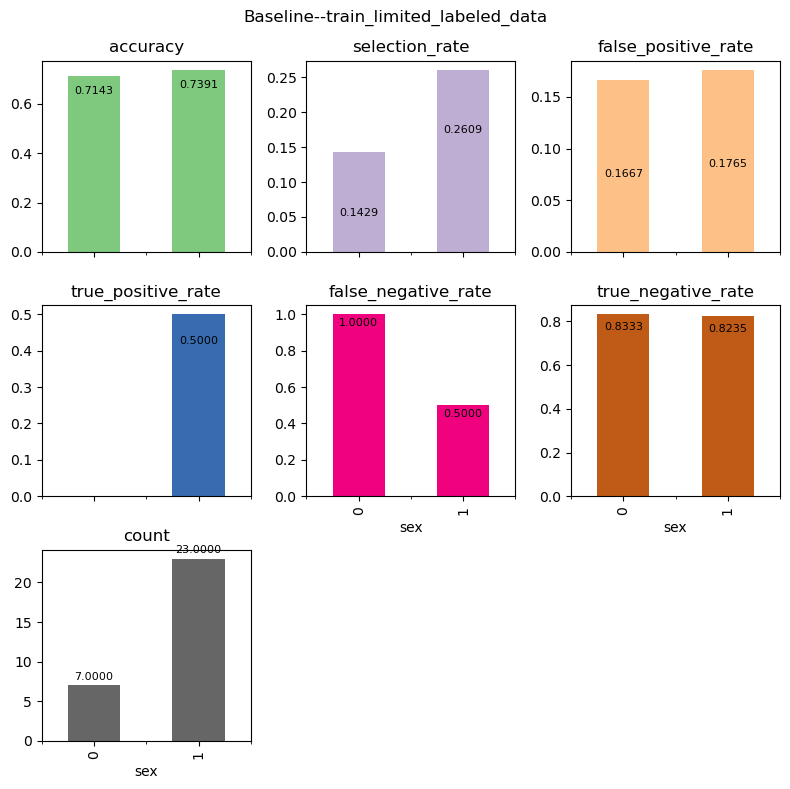

In [27]:
import matplotlib.pyplot as plt
from fairlearn.metrics import MetricFrame, selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,
           'false_positive_rate': false_positive_rate,
           'true_positive_rate': true_positive_rate,
           'false_negative_rate': false_negative_rate,
           'true_negative_rate': true_negative_rate,
              'count': count}

# sensitive feature in X_test
a_test = X_test['sex']

mf_original = MetricFrame(metrics=metrics,
                 y_true=y_test,
                 y_pred=y_pred,
                 sensitive_features=a_test)

print("Test set fairness metrics (before mitigation):")

# 绘制柱状图
ax = mf_original.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[8, 8],
    colormap="Accent",
    title="Baseline--train_limited_labeled_data",
)

# 显示数值
for subplot in ax.flatten():  # 遍历每个子图
    if subplot is not None:
        for bar in subplot.patches:  # 遍历每个柱子
            height = bar.get_height()
            subplot.annotate(
                f"{height:.4f}",  # 格式化数值
                xy=(bar.get_x() + bar.get_width() / 2, height-0.1),
                xytext=(0, 3),  # 在柱子上方稍微偏移一些
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=8
            )

# 显示图形
plt.tight_layout()
plt.show()


### 5.(补充) Evaluate the performance of model with sex balanced original train set 

In [30]:
original_DR_sex_balanced = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model_sex_balanced)
print(f'original_DR_sex_balanced: {original_DR_sex_balanced}')
if original_DR > original_DR_sex_balanced:
    print(f'使用sex balance后，DR值减小了{original_DR - original_DR_sex_balanced}')
else:
    print(f'使用sex balance后, DR值增加了{original_DR_sex_balanced - original_DR}')

original_DR_sex_balanced: 0.012902158312499523
使用sex balance后, DR值增加了0.00980948656797409


Test set fairness metrics (before mitigation):


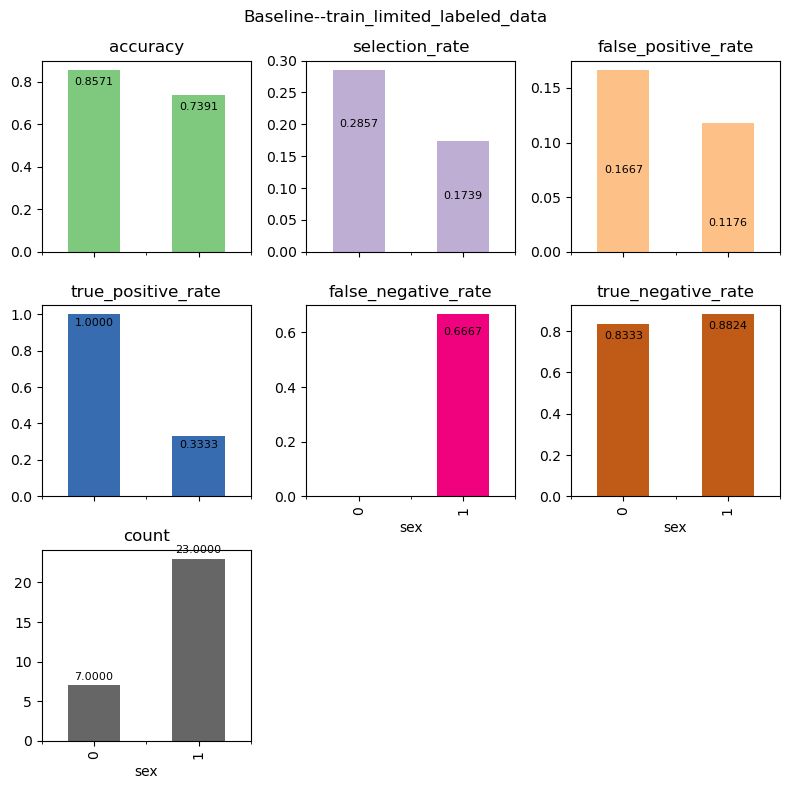

In [31]:
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,
           'false_positive_rate': false_positive_rate,
           'true_positive_rate': true_positive_rate,
           'false_negative_rate': false_negative_rate,
           'true_negative_rate': true_negative_rate,
              'count': count}

# sensitive feature in X_test
a_test = X_test['sex']

mf_original = MetricFrame(metrics=metrics,
                 y_true=y_test,
                 y_pred=y_pred_sex_balanced,
                 sensitive_features=a_test)

print("Test set fairness metrics (before mitigation):")

# 绘制柱状图
ax = mf_original.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[8, 8],
    colormap="Accent",
    title="Baseline--train_limited_labeled_data",
)

# 显示数值
for subplot in ax.flatten():  # 遍历每个子图
    if subplot is not None:
        for bar in subplot.patches:  # 遍历每个柱子
            height = bar.get_height()
            subplot.annotate(
                f"{height:.4f}",  # 格式化数值
                xy=(bar.get_x() + bar.get_width() / 2, height-0.1),
                xytext=(0, 3),  # 在柱子上方稍微偏移一些
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=8
            )

# 显示图形
plt.tight_layout()
plt.show()


### 6. Start the experiment!

>1. 只使用10%的labeled data 查看模型结果-baseline （见4, 5）
>
>2. 只使用10%的labeled data + sex balance查看模型结果
>
>3. 使用10%的labeled data， 再使用unlabel data把labeled data中的sex补齐。（使用model预测的值对unlabel data贴标签）
>
>4. 使用10%的labeled data， 再使用unlabel data时候，让新增的data中 sex balanced（使用model预测的值对unlabel data贴标签）
>
>5. 使用10%的labeled data + sex balance + new data (from unlabeled data) + sex balance + 使用labeled data中最相似的instance的标签
>
>6. 使用10%的labeled data + sex balance + new data (from unlabeled data) + sex balance + 通过pretrained model对data进行label标注
>
>7.☆☆  这里的sex balance是如何选取好点？ 是分别找sex=0和sex=1的nearest neighbour(此处数量怎么限制？按照少数的来？)。
>   还是把他们放在一个大池子里。统一挑出来，最后再限制个数为min(num_sex0, num_sex1)， 如果这样的话，对unlabeled data标注方式感觉不能直接使用原标签，是否用ml预测的结果会更好一点？

In [33]:
from src.experiments import Experiment

In [41]:
my_experiment = Experiment(
            orginal_model=model, 
            X_train=X_train, 
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            X_unlabel=X_unlabel,
            y_unlabel=y_unlabel,
            dataset_name='german_credit' )
'''
对于german credit，需要把 self.limited_values_range = np.arange(1, non_zero_count, 50)中的50 改成5
'''

'\n对于german credit，需要把 self.limited_values_range = np.arange(1, non_zero_count, 50)中的50 改成5\n'

In [42]:
# new_models_DR_values = my_experiment.get_result(
#             sex_balance = False, 
#             proportion = 0.5,
#             replacement = True, 
#             num_new_data = 3,
#             matcher = 'nn')

new_models_DR_values = my_experiment.get_sex_separate_nn_result(
    sex_balance=False,
    proportion=0.6,
    replacement=True,
    num_new_data=3,
    matcher='nn',
    match_method='sex_separate'
)


开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 200
Proporation: 0.6, new_data_number: 3 训练结束, match_method:sex_separate,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------


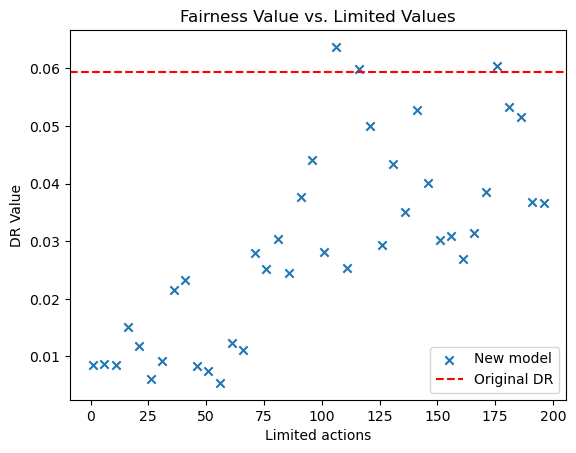

In [43]:
my_experiment.visualize(new_models_DR_values)

开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 68
Proporation: 0.2, new_data_number: 1 训练结束, match_method:together,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 121
Proporation: 0.2, new_data_number: 2 训练结束, match_method:together,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_tr

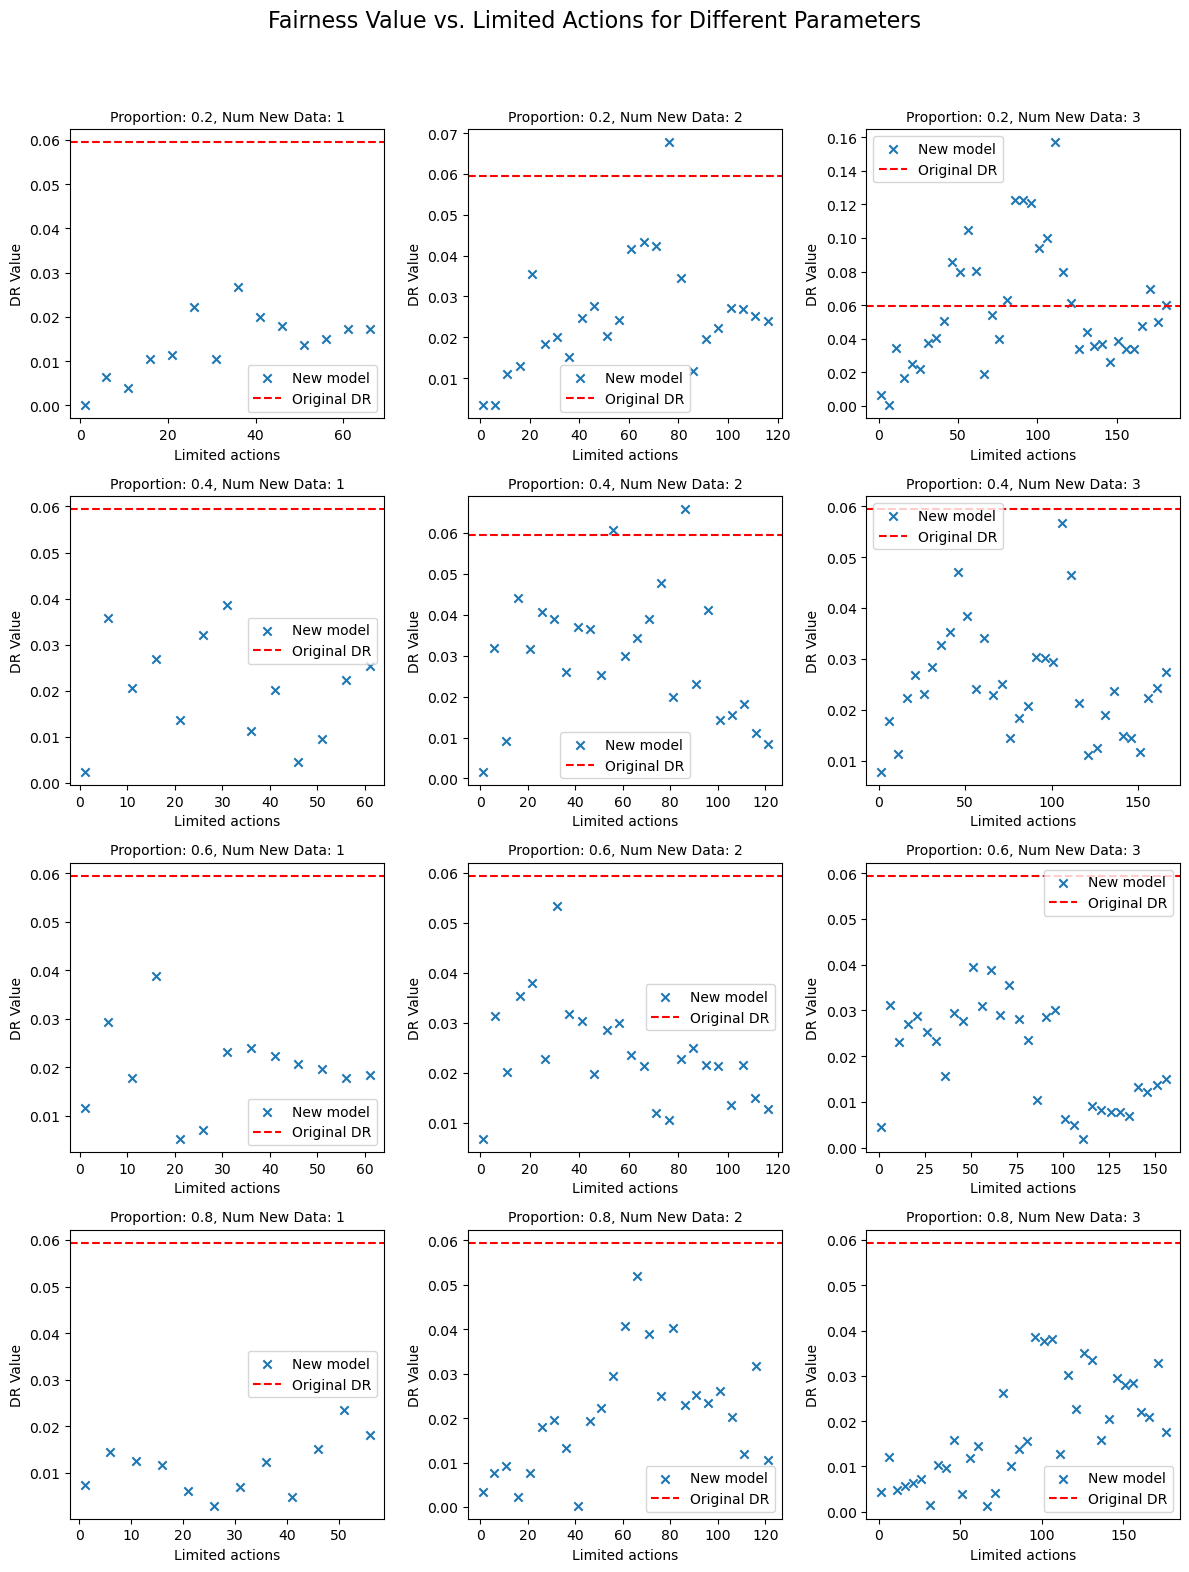

In [44]:
results = my_experiment.combination(match_met='together')

开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 67
Proporation: 0.2, new_data_number: 1 训练结束, match_method:sex_separate,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 140
Proporation: 0.2, new_data_number: 2 训练结束, match_method:sex_separate,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好,

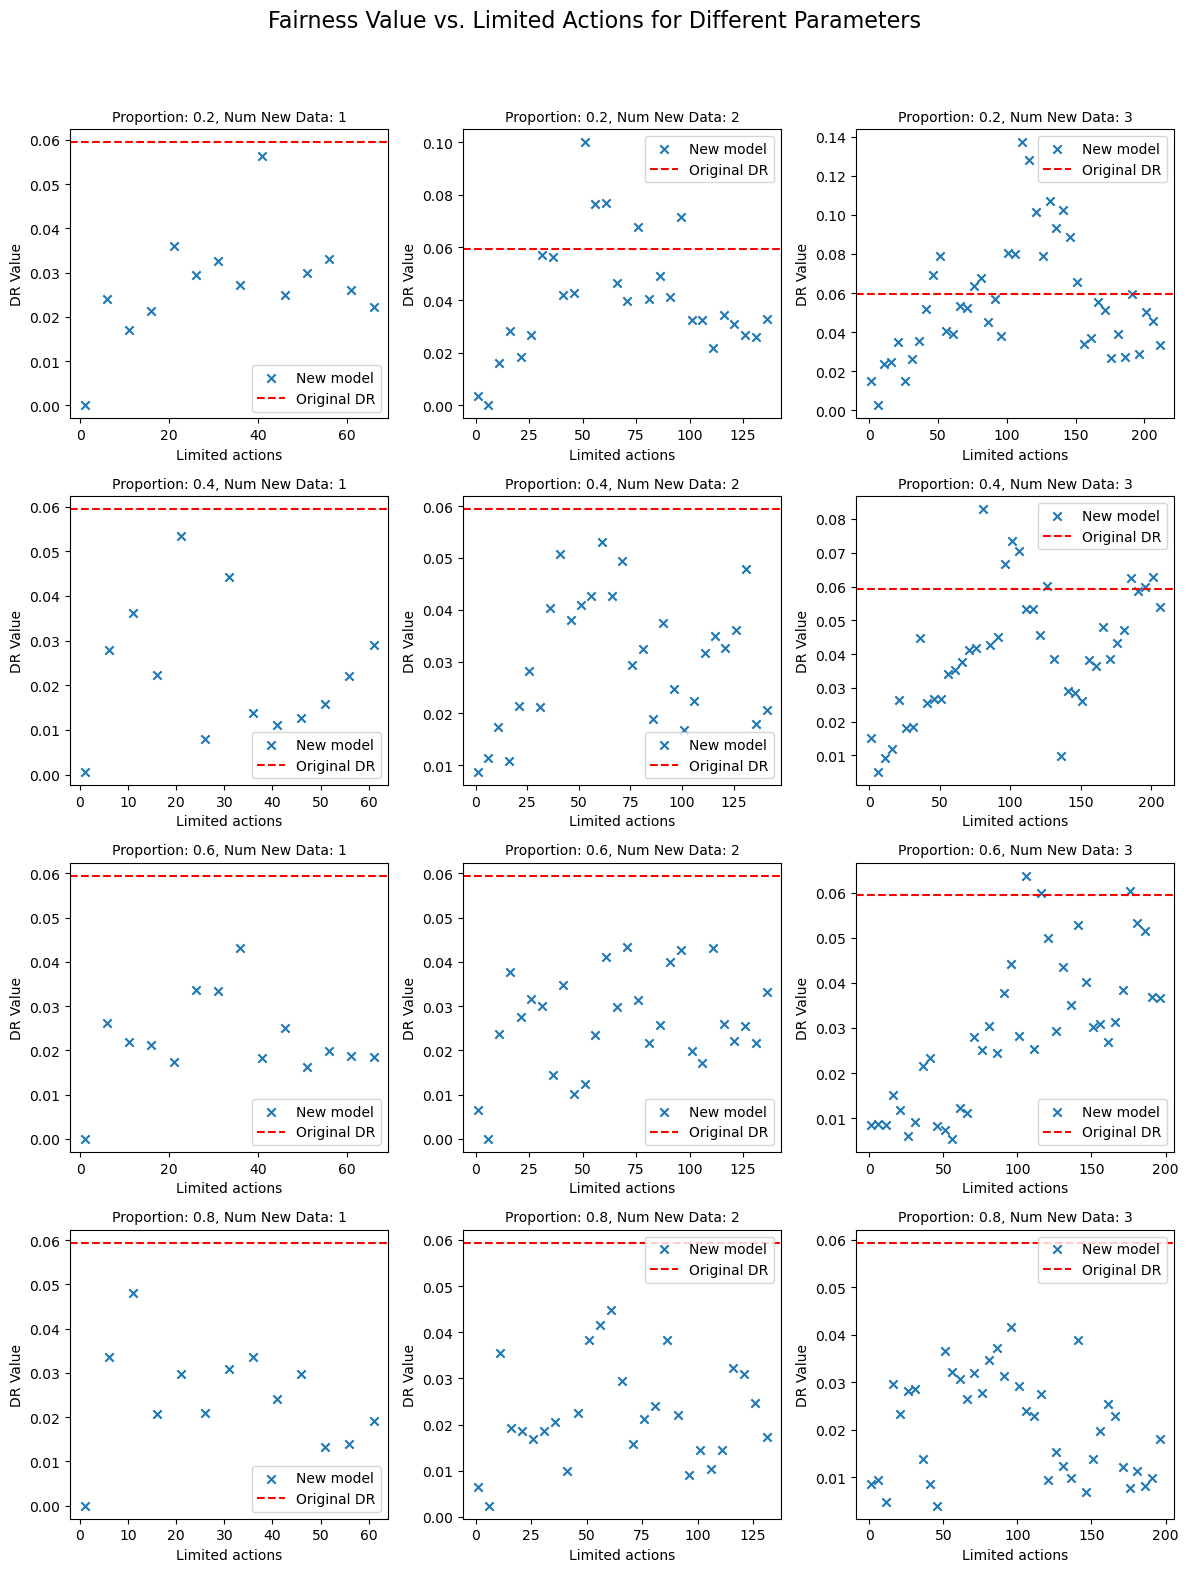

In [45]:
results_sex_separate = my_experiment.combination(match_met='sex_separate')

开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 183
Proporation: 0.6, new_data_number: 3 训练结束, match_method:sex_cross,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------


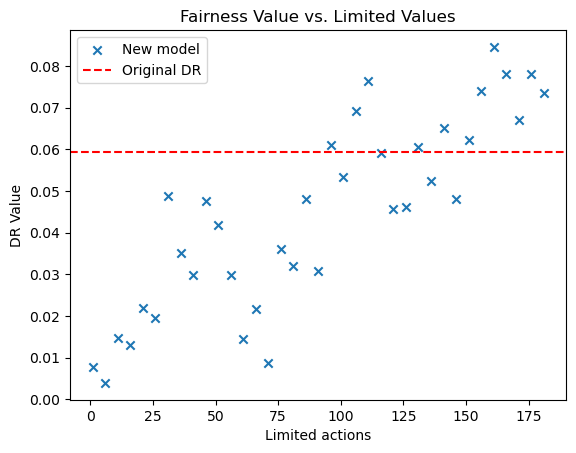

In [46]:
sex_cross_DR_values = my_experiment.get_sex_separate_nn_result(
    sex_balance=False,
    proportion=0.6,
    replacement=True,
    num_new_data=3,
    matcher='nn',
    match_method='sex_cross'
)
my_experiment.visualize(sex_cross_DR_values)

开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 74
Proporation: 0.2, new_data_number: 1 训练结束, match_method:sex_cross,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 137
Proporation: 0.2, new_data_number: 2 训练结束, match_method:sex_cross,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_

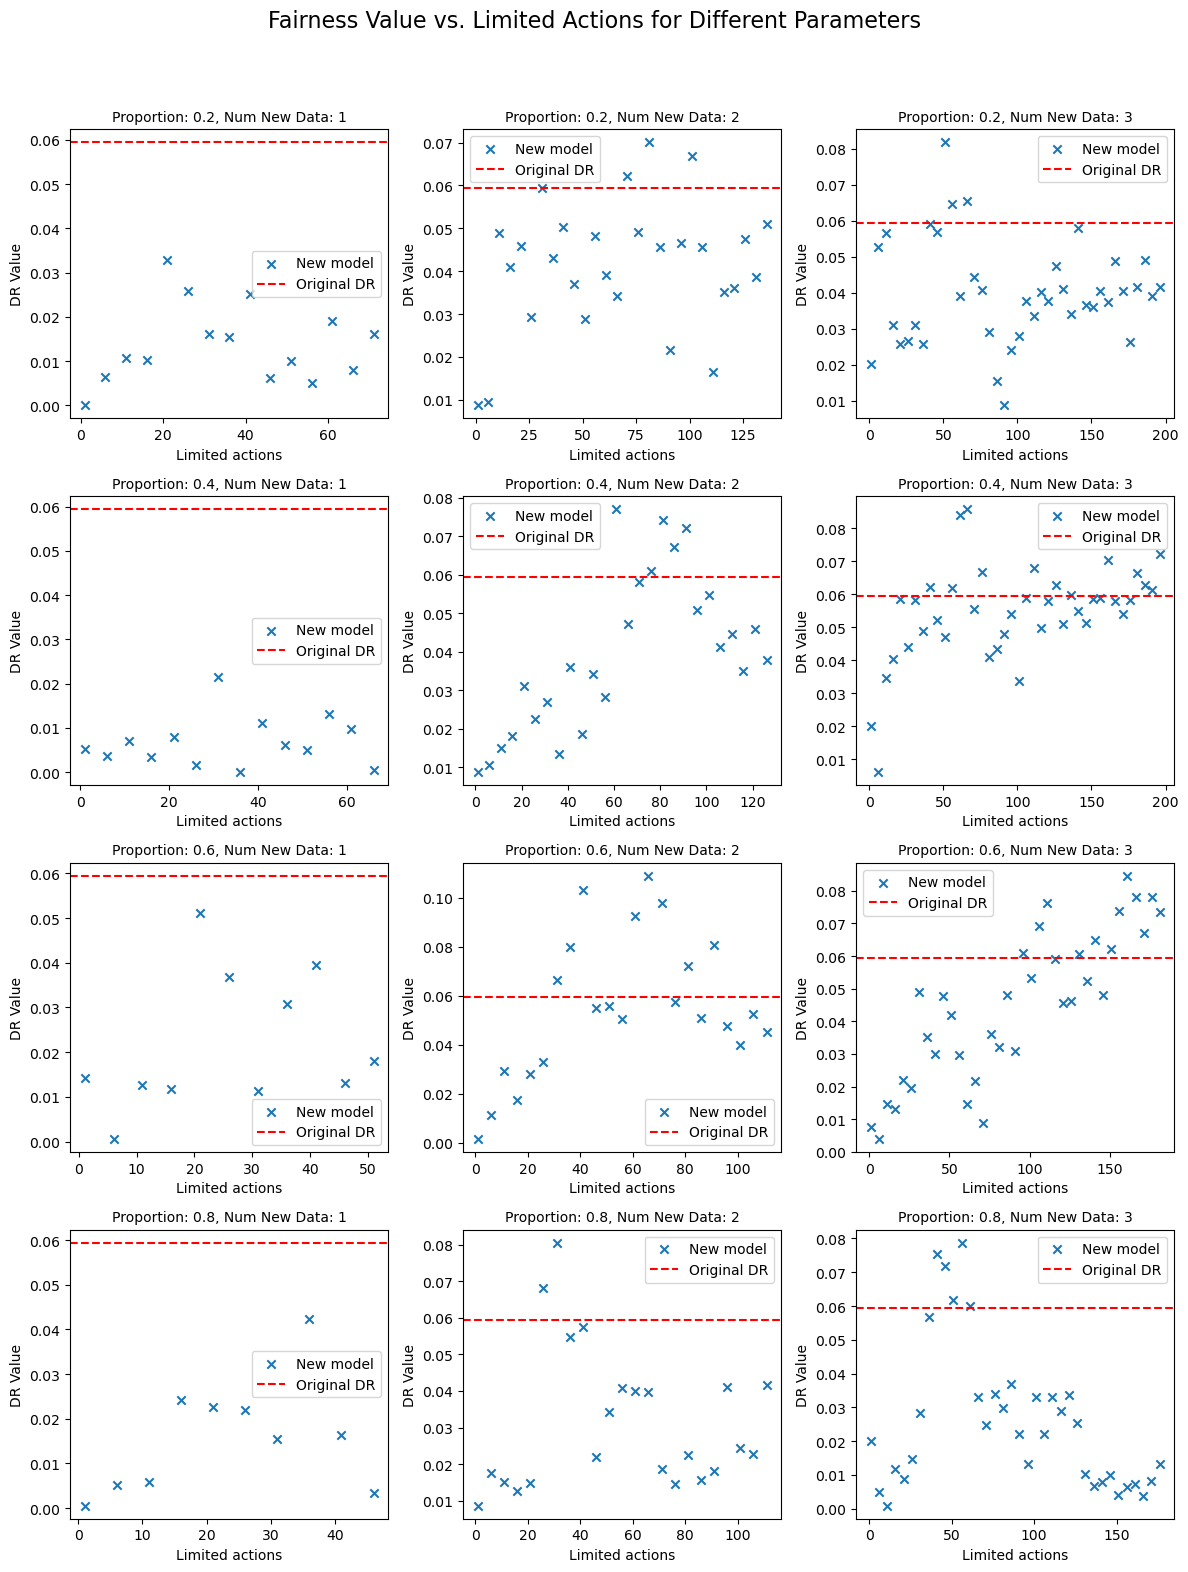

In [47]:
results_sex_cross = my_experiment.combination(match_met='sex_cross')